16


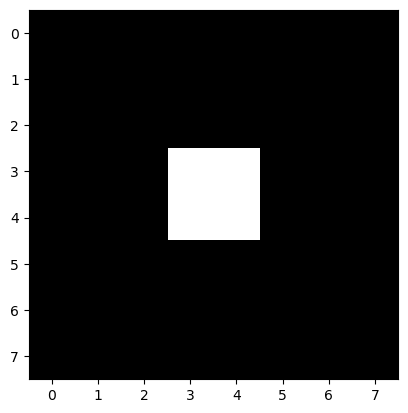

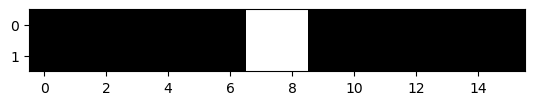

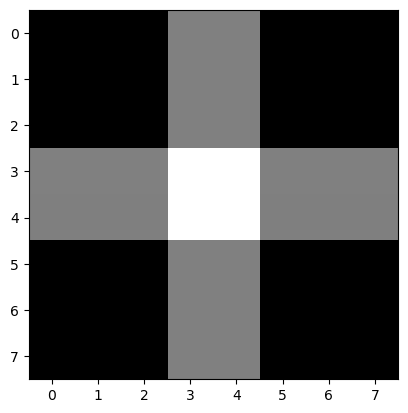

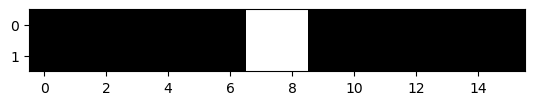

In [17]:
import astra
import numpy as np

N = 8
M = int(2 ** np.ceil(np.log2(N * np.sqrt(2))))
print(M)

vol_geom = astra.create_vol_geom(N, N)
proj_geom = astra.create_proj_geom('parallel', 1.0, M, np.linspace(0,np.pi,2,False))

# For CPU-based algorithms, a "projector" object specifies the projection
# model used. In this case, we use the "strip" model.
proj_id = astra.create_projector('strip', proj_geom, vol_geom)

# Create a phantom
phantom = np.zeros((N, N))
center = N // 2
phantom[center-1:center+1, center-1:center+1] = 1
phantom_id = astra.data2d.create('-vol', vol_geom, phantom)
    
sinogram_id, sinogram = astra.create_sino(phantom_id, proj_id)

import pylab
pylab.gray()
pylab.figure(1)
pylab.imshow(phantom)
pylab.figure(2)
pylab.imshow(sinogram)

# Create a data object for the reconstruction
rec_id = astra.data2d.create('-vol', vol_geom)

# Set up the parameters for a reconstruction algorithm using the CPU
# The main difference with the configuration of a GPU algorithm is the
# extra ProjectorId setting.
cfg = astra.astra_dict('SIRT')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id

# Available algorithms:
# ART, SART, SIRT, CGLS, FBP


# Create the algorithm object from the configuration structure
alg_id = astra.algorithm.create(cfg)

# Run 20 iterations of the algorithm
# This will have a runtime in the order of 10 seconds.
astra.algorithm.run(alg_id, 20)

# Get the result
rec = astra.data2d.get(rec_id)
pylab.figure(3)
pylab.imshow(rec)
pylab.show()

# Playing wih weight matrix
# Generate the projection matrix for this projection model.
# This creates a matrix W where entry w_{i,j} corresponds to the
# contribution of volume element j to detector element i.
matrix_id = astra.projector.matrix(proj_id)

# Get the projection matrix as a Scipy sparse matrix.
W = astra.matrix.get(matrix_id)


# Manually use this projection matrix to do a projection:
s = W.dot(phantom.ravel())
s = np.reshape(s, (len(proj_geom['ProjectionAngles']),proj_geom['DetectorCount']))

import pylab
pylab.gray()
pylab.figure(1)
pylab.imshow(s)
pylab.show()

# Clean up.
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.data2d.delete(phantom_id)
astra.projector.delete(proj_id)

In [16]:
import astra
import numpy as np
from scipy.sparse.linalg import lsqr

# Parameters
N = 8
M = int(2 ** np.ceil(np.log2(N * np.sqrt(2))))
angles = np.linspace(0, np.pi, 2, False)

# Create geometries
vol_geom = astra.create_vol_geom(N, N)
proj_geom = astra.create_proj_geom('parallel', 1.0, M, angles)
proj_id = astra.create_projector('strip', proj_geom, vol_geom)

# Create phantom
phantom = np.zeros((N, N))
center = N // 2
phantom[center - 1:center + 1, center - 1:center + 1] = 1
phantom_id = astra.data2d.create('-vol', vol_geom, phantom)

# Generate sinogram using ASTRA
sinogram_id, sinogram = astra.create_sino(phantom_id, proj_id)

# ART reconstruction (via ASTRA)
rec_id = astra.data2d.create('-vol', vol_geom)
cfg = astra.astra_dict('ART')
cfg['ReconstructionDataId'] = rec_id
cfg['ProjectionDataId'] = sinogram_id
cfg['ProjectorId'] = proj_id
alg_id = astra.algorithm.create(cfg)
astra.algorithm.run(alg_id, 20)
rec_art = astra.data2d.get(rec_id)

# Custom FBP-like reconstruction using system matrix
matrix_id = astra.projector.matrix(proj_id)
W = astra.matrix.get(matrix_id)  # sparse matrix
rec_fbp = lsqr(W, sinogram.ravel())[0].reshape(N, N)

# Clean up ASTRA memory
astra.algorithm.delete(alg_id)
astra.data2d.delete(rec_id)
astra.data2d.delete(sinogram_id)
astra.data2d.delete(phantom_id)
astra.projector.delete(proj_id)
astra.matrix.delete(matrix_id)

# Return relevant data for further use
result = {
    "phantom": phantom,
    "sinogram": sinogram,
    "rec_art": rec_art,
    "rec_fbp": rec_fbp,
    "system_matrix": W,
}


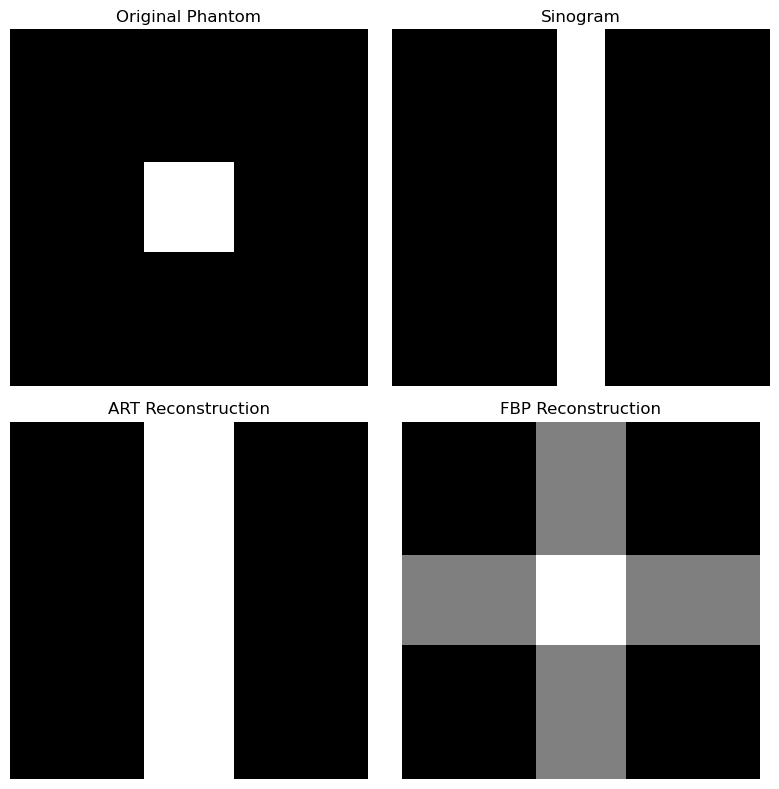

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def plot_reconstruction_grid(phantom, sinogram, rec_art, rec_fbp):
    """
    Plot a 2x2 comparison grid:
    (0,0): Original phantom
    (0,1): Sinogram
    (1,0): ART reconstruction
    (1,1): FBP reconstruction
    """
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    plt.gray()

    axes[0, 0].imshow(phantom)
    axes[0, 0].set_title('Original Phantom')

    axes[0, 1].imshow(sinogram, aspect='auto')
    axes[0, 1].set_title('Sinogram')

    axes[1, 0].imshow(rec_art)
    axes[1, 0].set_title('ART Reconstruction')

    axes[1, 1].imshow(rec_fbp)
    axes[1, 1].set_title('FBP Reconstruction')

    for ax in axes.ravel():
        ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_reconstruction_grid(
    result["phantom"],
    result["sinogram"],
    result["rec_art"],
    result["rec_fbp"]
)
